In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import glob
import os
import matplotlib.pyplot as plt

# Load Data

In [2]:
path = 'data/csv_files'
files = glob.glob(os.path.join(path, '*.csv'))

li = []

for filename in files: 
    frame = pd.read_csv(filename, header=0)
    li.append(frame)

df_full = pd.concat(li, axis=0, ignore_index=True)
# df= pd.read_csv('data/out_test.csv')

C:\Users\hanna\AppData\Local\Temp/ipykernel_17560/1728045614.py:7: DtypeWarning: Columns (12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  frame = pd.read_csv(filename, header=0)


In [3]:
df_full.head()

,id,lang,authors,title,subtitle,statement,place,publisher,year,editors,subjects,subject_types,parentId,parentTitle
0,BV000023649,ger,NaN,"Deutsches Literaturarchiv, Schiller-Nationalmu...",NaN,vorgestellt von den Mitarbeitern,Marbach a. Neckar,NaN,1982,NaN,Deutsches Literaturarchiv Marbach,b,BV040655651,Marbacher Schriften
1,BV000024214,ger,"Schlink, Wilhelm",Jacob Burckhardt und die Kunsterwartung im Vor...,NaN,Wilhelm Schlink,Wiesbaden,Steiner,1982,NaN,"Burckhardt, Jacob|Deutschland|Historienmalerei",p|g|s,BV000000154,Frankfurter historische Vorträge
2,BV000024767,ger,"Burckhardt, Jacob",Über das Studium der Geschichte,NaN,Jacob Burckhardt. Nach den Handschriften herau...,München,Verlag C.H.Beck,1982,"Ganz, Peter F.|Ziegler, Ernst","Geschichtsstudium|Burckhardt, Jacob",s|p,NaN,NaN
3,BV000025578,ger,"Herzog, Werner",Fitzcarraldo,NaN,Werner Herzog,München u.a.,Hanser,1982,NaN,"Fitzcarraldo|Herzog, Werner",u|p,NaN,NaN
4,BV000026429,ita,"Rotili, Mario",Filippo Raguzzini nel terzo centenario della n...,NaN,NaN,Napoli,Soc. Ed. Napoletana,1982,"Rauzzini, Filippo","Rauzzini, Filippo",p,BV000000758,Studi e testi di storia e critica dell'arte


In [4]:
df = df_full.sample(n=10000)

# Data exploration and Cleaning

### Subject labels

The subject labels and types are saved as a string using '|' as seperator

In [5]:
# documents without subjects

without_subject = df.subjects.isnull().sum() * 100 / len(df)
print("Percentage of documents without subjects: {0:.2f}% ".format(without_subject))

Percentage of documents without subjects: 47.63% 


In [6]:
# drop documents without subject labels

df.dropna(subset=['subjects'], inplace=True)
df['subjects'].isna().sum()

0

In [7]:
# cleaning the subject types
subject_list = df['subject_types'].str.split('|')

# cleaning up the subject: getting rid of commas and spaces, replacing the | with spaces
df['subject_list'] = df['subjects'].apply(lambda x: str(x).replace(',', '').replace(' ', '').replace('|', ' '))

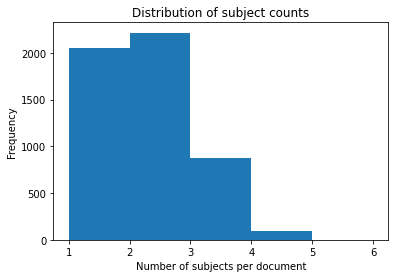

In [8]:
# how many subjects per document

counts = df.subjects.apply(lambda x : len(str(x).split('|')))

# plot a histogram of the counts
plt.hist(counts, bins=range(1, max(counts) + 2))
plt.xlabel('Number of subjects per document')
plt.ylabel('Frequency')
plt.title('Distribution of subject counts')
plt.show()


### ParentIds

- Volumes with parentid: Volumes of works have a parent entry in the bvb catalogue, all the children point to it in the parentid field. If the documents are present in the BH, the children have a shelf number, the parent document doesn't. Often neither contain subjects (as they are e.g. encyclopedias)

In [9]:
#parentids

grouped = df.groupby('parentId').size()
parents = df[df.id.isin(grouped.index)]
without_subject = parents.subjects.isnull().sum() * 100 / len(parents)
print("Percentage of documents without subjects: {0:.2f}% ".format(without_subject))

Percentage of documents without subjects: nan% 


C:\Users\hanna\AppData\Local\Temp/ipykernel_17560/1611735594.py:5: RuntimeWarning: invalid value encountered in longlong_scalars
  without_subject = parents.subjects.isnull().sum() * 100 / len(parents)


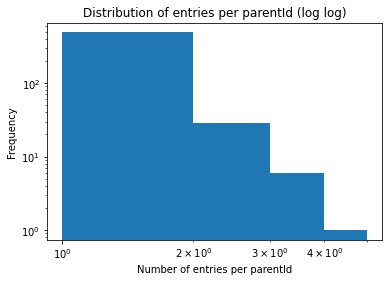

In [10]:
# plot a histogram of the size values on a log log plot to show the power law
plt.hist(grouped, bins=range(1, max(grouped) + 2))
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Number of entries per parentId')
plt.ylabel('Frequency')
plt.title('Distribution of entries per parentId (log log)')
plt.show()


In [11]:
# Volumes children and subject labels

volumes = df[~df.parentId.isna()]
without_subject = volumes.subjects.isnull().sum() * 100 / len(volumes)
print("Percentage of documents without subjects: {0:.2f}% ".format(without_subject))

Percentage of documents without subjects: 0.00% 


The volume with most entries is an auction catalogue: Christie, Manson & Woods

In [12]:
max_id = grouped.idxmax()
df[df.parentId == max_id].head()

,id,lang,authors,title,subtitle,statement,place,publisher,year,editors,subjects,subject_types,parentId,parentTitle,subject_list
1046114,BV047117233,eng,NaN,Prophecy and prophets in the Middle Ages,NaN,a cura di Alessandro Palazzo e Anna Rodolfi,Firenze,SISMEL - Edizioni del Galluzzo,2020,"Palazzo, Alessandro|Rodolfi, Anna",Prophet,s,BV012182314,Micrologus library,Prophet
87070,BV022368084,ita,"Faes De Mottoni, Barbara",Figure e motivi della contemplazione nelle teo...,NaN,Barbara Faes de Mottoni,Firenze,"SISMEL, Edizioni del Galluzzo",2007,NaN,"Kontemplation|Faes De Mottoni, Barbara",s|p,BV012182314,Micrologus' library,Kontemplation FaesDeMottoniBarbara
1171992,BV047946390,ita,NaN,L'éloquence du visage entre Orient et Occident,NaN,textes réunis par Oleg Voskoboynikov,Firenze,SISMEL - Edizioni del Galluzzo,2022,"Voskobojnikov, Oleg S.",Gesicht,s,BV012182314,Micrologus' library,Gesicht
59275,BV014052486,fre,"Paravicini Bagliani, Agostino","Le Speculum astronomiae, une énigme?",NaN,Agostino Paravicini Bagliani,Firenze,"SISMEL, Ed. del Galluzzo",2001,NaN,Autorschaft|Speculum astronomiae|Albertus (Mag...,s|u|p,BV012182314,Micrologus' library,Autorschaft Speculumastronomiae Albertus(Magnu...


### Publication year
The year column is very messy. I'm trying to extract only the year for each 

In order to extract only the year (which is hopefully present in all rows with a publication year entry), I'm trying a regex pattern match with 4 digits exactly

In [13]:
df.year.isna().sum()

2

In [14]:
df['year_clean'] = df.year.str.extract(r'(\d{4})')
df['year_clean'] = pd.to_numeric(df['year_clean'], errors='coerce')


In [15]:
# distribution of years

grouped = df.groupby('year_clean').size()


In [16]:
funny_years = df[df.year_clean.apply(lambda x: float(x) > 2023)]
funny_years

,id,lang,authors,title,subtitle,statement,place,publisher,year,editors,subjects,subject_types,parentId,parentTitle,subject_list,year_clean


In [17]:
# drop rows that are obviously not valid years

mask = (df['year_clean'] <= 2023) & (df['year_clean'] != 0)

df= df.loc[mask]

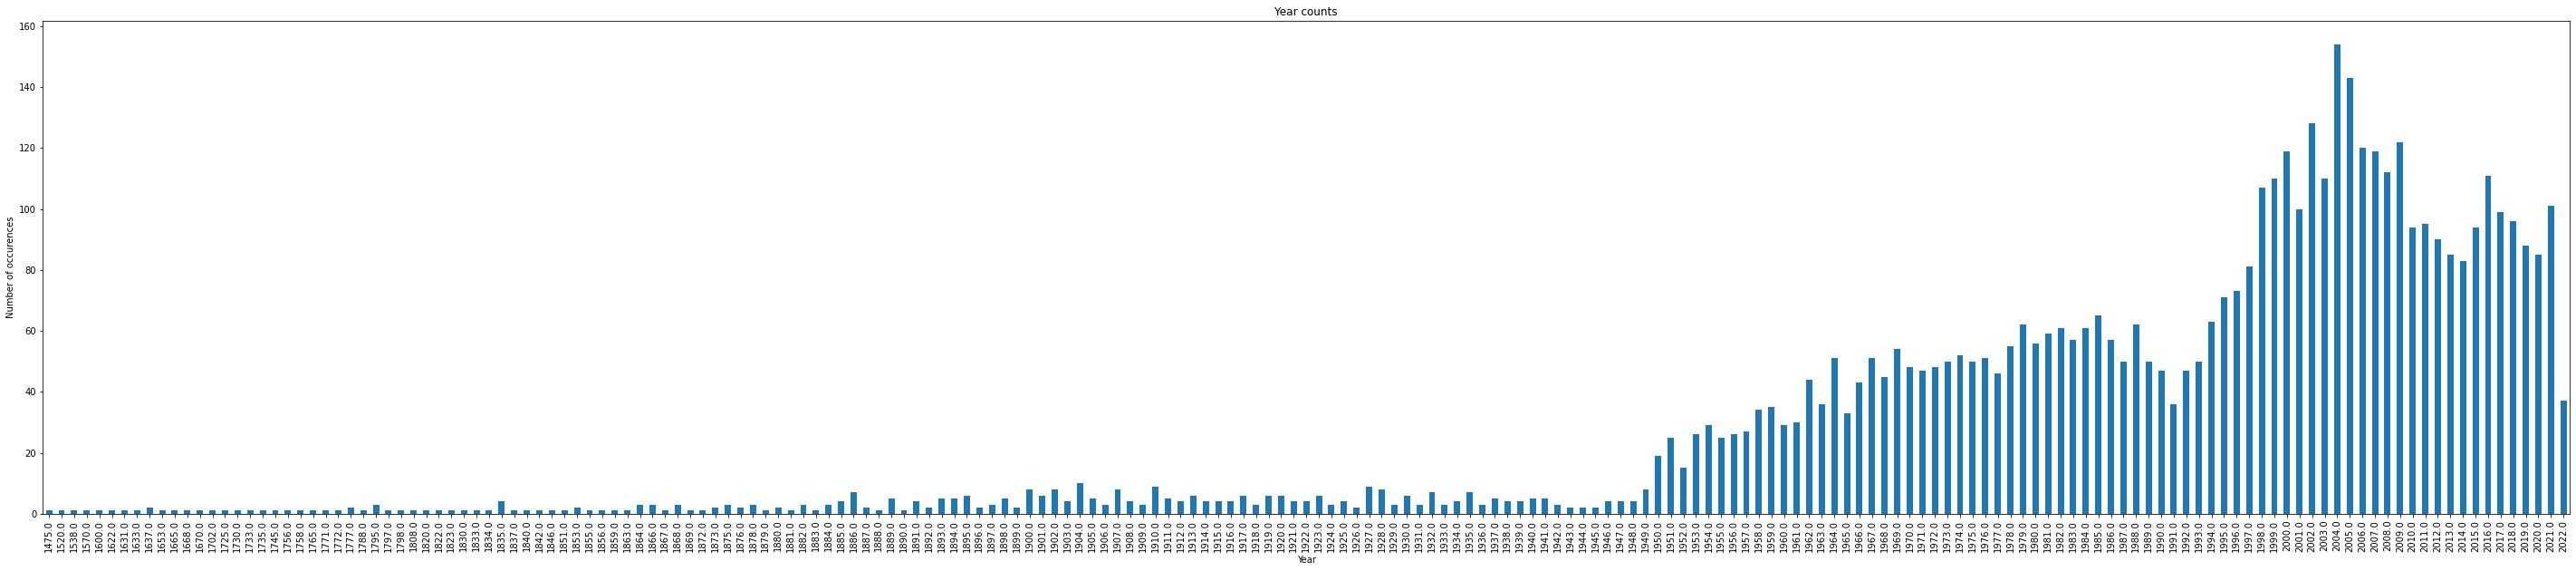

In [18]:
# distribution of years

grouped = df.groupby('year_clean').size()

fig = plt.figure(figsize=(50, 10))
grouped.plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Number of occurences')
plt.title('Year counts')
plt.show()


In [19]:
min(grouped.index)

1475.0

### Catalogue Info
- Acquisition date: before 2012 approx. the date of acquisition is in the 'Inventarnummer' field. It contains the year and the how manyth document it is in a given year (linear time information). After 2012 the date of acquisition is in the acquisition date field


In [20]:
# drop documents that belong to a Volume of works (with parentid)

#df[df.parentId.isna()]

## Bag of words

In [21]:
vectorizer = CountVectorizer(min_df=5)
subject_doc_matrix = vectorizer.fit_transform(df.subject_list)

In [22]:
subject_doc_matrix

<5220x264 sparse matrix of type '<class 'numpy.int64'>'
	with 4354 stored elements in Compressed Sparse Row format>

In [23]:
df[df.subject_list.apply(lambda x: len(str(x)) < 4)]

,id,lang,authors,title,subtitle,statement,place,publisher,year,editors,subjects,subject_types,parentId,parentTitle,subject_list,year_clean
137878,BV037650725,ger,NaN,Erdengötter,NaN,ein Katalog von Annette Reiter,Greiz,NaN,1998,"Reiter, Annette",Hof,s,NaN,NaN,Hof,1998.0
1018212,BV046260599,ita,"Sapori, Francesco",Da Roma al Circeo,NaN,Francesco Sapori,Firenze,Casa editrice NEMI del Dott. C. Cherubini,1932.,NaN,Rom,g,NaN,NaN,Rom,1932.0
291455,BV038013655,ger,"Pietrus, Ellen",Die Veredelung des Menschen - Einrichtungen zu...,NaN,NaN,NaN,NaN,2006,NaN,Bad,s,NaN,NaN,Bad,2006.0
832424,BV038899103,eng,NaN,Clock & watch designs,NaN,NaN,Lawrence/Kan.,NaN,1967,NaN,Uhr,s,BV018075741,Miscellaneous publications of the Museum of Art,Uhr,1967.0
713839,BV038624434,hrv,"Žic-Rokov, Ivan",Romanička crkva Mqjke Božje od Zdravlja u Krku...,NaN,Ivan Žic-Rokov,NaN,NaN,[ca.1974],NaN,Krk,g,NaN,NaN,Krk,1974.0
448116,BV038237138,ger,"Ahrens, Dieter",Literaturgeschichte und Baugeschichte in ausge...,NaN,NaN,NaN,NaN,1986,NaN,Rom,g,NaN,NaN,Rom,1986.0


### UMAP

In [24]:
import matplotlib.pyplot as plt
from umap.umap_ import UMAP
import umap.plot
from pointgrid import align_points_to_grid

In [25]:
# reducer = UMAP(random_state=42, n_components = 2, metric='cosine')
reducer = UMAP(random_state=42, n_components = 2, min_dist=0.01, n_neighbors=3, metric='cosine')

# Using hellinger metric the points without neighbors are mapped to nan. 

map = reducer.fit(subject_doc_matrix)

c:\Users\hanna\anaconda3\envs\ada\lib\site-packages\umap\plot.py:448: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(points[:, 0], points[:, 1], s=point_size, c=color)


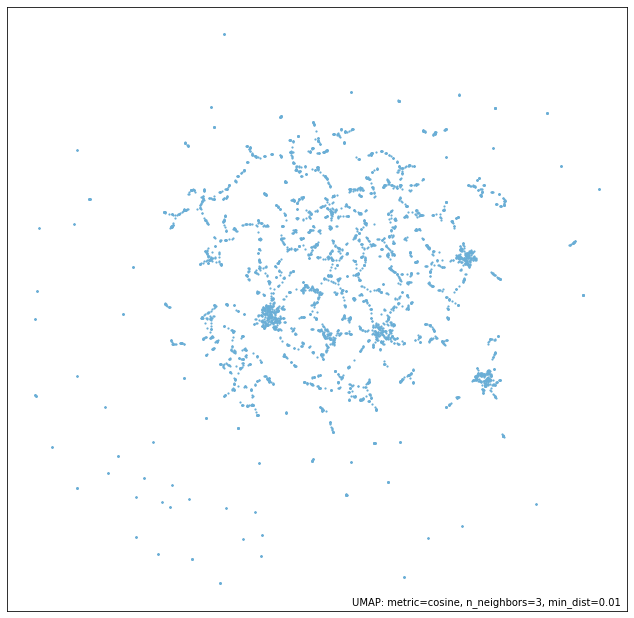

In [26]:
f = umap.plot.points(map)

In [27]:
map.embedding_

array([[ 5.0691934, 12.517024 ],
       [ 5.3301005,  3.4274824],
       [ 0.2642569,  2.9096048],
       ...,
       [ 3.1559067, 12.287732 ],
       [ 6.3191895, 12.924032 ],
       [ 2.320761 ,  6.2167516]], dtype=float32)

In [28]:
# Normalize 

embedding = map.embedding_ * 100 # Multiply by 100
embedding = align_points_to_grid(embedding)

# Swap axes for horizontal position

ptp = np.ptp(embedding, axis=0)
if ptp[1]> ptp[0]:
    embedding[:, [1, 0]] = embedding[:, [0, 1]]

# Set value starting from 0

embedding[:, 0] = embedding[:, 0] - embedding[:, 0].min()
embedding[:, 1] = embedding[:, 1] - embedding[:, 1].min()

# # Set origin at the middle

ptp = np.ptp(embedding, axis=0)  
embedding[:, 0] = embedding[:, 0] - ptp[0] / 2
embedding[:, 1] = embedding[:, 1] - ptp[1] / 2

embedding = embedding.astype(int) # Set integer

embedding

array([[ 576,   72],
       [-331,   96],
       [-368, -421],
       ...,
       [ 552, -120],
       [ 650,  168],
       [-233, -216]])

# Cluster Identification

In [29]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=50, cluster_selection_method ='leaf')

clusterer.fit(embedding)
clusters = clusterer.labels_

values = set(clusters)
if -1 in values: values.remove(-1)

#clusters = [[index for index, cluster in enumerate(clusters) if cluster==value] for value in values]

# add cluster to dataframe

df['cluster'] = clusters


In [30]:
df.groupby('cluster').size()

cluster
-1    3988
 0     241
 1      50
 2      80
 3     121
 4      50
 5     185
 6     109
 7     160
 8      75
 9     161
dtype: int64

# Word Clouds


In [31]:
from wordcloud import WordCloud
from PIL import Image, ImageDraw

## Export 

In [35]:
# add coordinates to dataframe

df['embedding_x']  = embedding[:,0]
df['embedding_y']  = embedding[:,1]



df.head()

,id,lang,authors,title,subtitle,statement,place,publisher,year,editors,subjects,subject_types,parentId,parentTitle,subject_list,year_clean,cluster,embedding_x,embedding_y
732231,BV038653346,ger,"Cinthio, Erik",Der thronende Christus mit Stola,NaN,Erik Cinthio,NaN,NaN,1962,NaN,Ikonographie|Jesus Christus,s|p,NaN,NaN,Ikonographie JesusChristus,1962.0,-1,576,72
544643,BV038356372,spa,"García Cuesta, Timoteo","El primitivo santuario de Nuestra Señora, de l...",NaN,Timoteo García Cuesta,NaN,NaN,1967,NaN,"Praves, Francisco de",p,NaN,NaN,PravesFranciscode,1967.0,-1,-331,96
1031883,BV046793000,ger,"Schuster, Esther-Luisa",Im Haus der Weisheit,NaN,Esther-Luisa Schuster ; mit einem Beitrag von ...,Regensburg,Schnell & Steiner,2020,"Thalguter, Nadia",Dom Hildesheim|Westbau,g|s,BV044542238,Objekte und Eliten in Hildesheim 1130 bis 1250,DomHildesheim Westbau,2020.0,-1,-368,-421
237956,BV037930235,ita,"Bertozzi, Elisabetta",I portici lignei a Bologna,NaN,NaN,NaN,NaN,1994,NaN,Bologna|Architektur,g|s,NaN,NaN,Bologna Architektur,1994.0,-1,-355,265
637807,BV038505926,ita,"Agnello, Giuseppe",Recenti esplorazioni nelle catacombe Cassia e ...,NaN,Giuseppe Agnello,NaN,NaN,1971,NaN,Syrakus,g,NaN,NaN,Syrakus,1971.0,-1,809,132


In [39]:
columns_export =['id', 'lang', 'title', 'year', 'embedding_x', 'embedding_y', 'cluster']

path_out = 'data/mapping_out_sample.csv'
#path_out = 'data/mapping_out_all.csv'

df[columns_export].to_csv(path_out)

# Appendix

## TF-IDF

In [25]:
tfidf = TfidfVectorizer(min_df=5)
tfidf_subject_matrix = tfidf.fit_transform(df.subject_list)


In [26]:
tfidf_subject_matrix

<7302x429 sparse matrix of type '<class 'numpy.float64'>'
	with 7762 stored elements in Compressed Sparse Row format>

In [27]:
tfidf_embedding = UMAP(random_state=42, n_components = 2, metric='hellinger').fit(tfidf_subject_matrix)


c:\Users\hanna\anaconda3\envs\ada\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 25045 edges.
It has fully disconnected 1145 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


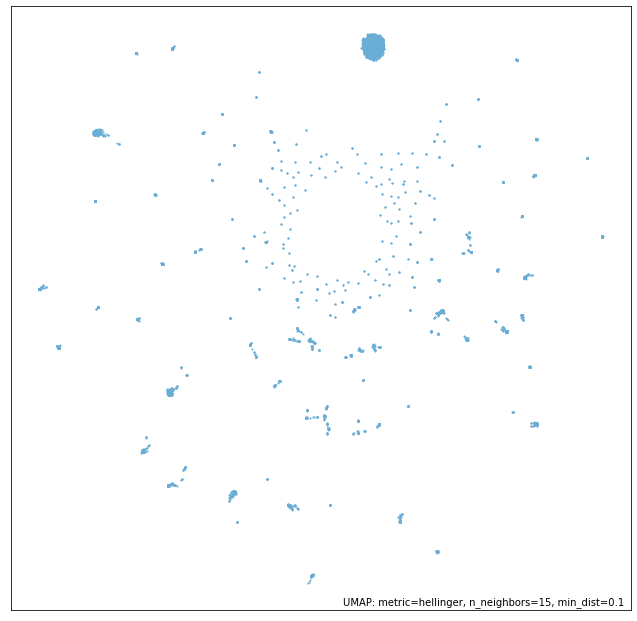

In [28]:
f = umap.plot.points(tfidf_embedding)